In [21]:
# -*- coding: utf-8 -*-

import functools
import numpy as np
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection


import pso
import ann
#activationLayer="tanh"
#np.random.seed(6663)
def dim_weights(shape):
    dim = 0
    for i in range(len(shape)-1):
        dim = dim + (shape[i] + 1) * shape[i+1]
    return dim

def weights_to_vector(weights):
    w = np.asarray([])
    for i in range(len(weights)):
        v = weights[i].flatten()
        w = np.append(w, v)
    return w

def vector_to_weights(vector, shape):
    weights = []
    idx = 0
    for i in range(len(shape)-1):
        r = shape[i+1]
        c = shape[i] + 1
        idx_min = idx
        idx_max = idx + r*c
        W = vector[idx_min:idx_max].reshape(r,c)
        weights.append(W)
    return weights



#this is the optimisation for the coords of the particles??
def eval_neural_network(weights, shape, X, y,activationLayer):
    mse = np.asarray([])
    for w in weights:
        weights = vector_to_weights(w, shape)
        nn = ann.MultiLayerPerceptron(shape, weights=weights)
        y_pred = nn.run(X,activationLayer)
        mse = np.append(mse, sklearn.metrics.mean_squared_error(np.atleast_2d(y), y_pred))
    return mse

def print_best_particle(best_particle):
    print("New best particle found at iteration #{i} with mean squared error: {score}".format(i=best_particle[0], score=best_particle[1]))




#just xy error = 0.22938741634873416
#with sinx sin y error = 0.2325498216710004
#with sin and sq error = 0.21790465807135315

In [22]:

def sine(X):
    return np.sin(X)


#loading Starts here

def sq(X):
    return np.power(X,2)

num_classes = 2
f = open("two_spirals.dat","r")
data = np.loadtxt(f)
X = data[:,0:2]
y = data[:,2]
y = y.astype(int)


def generateData(X,y,ratio,sin=False,square=False):
    if sin and square:
        X = np.hstack((X,np.hstack((sq(X),sine(X)))))
      #  print(X[0])
    elif sin:
        X=np.hstack((X,sine(X)))
    elif square:
        X = np.hstack((X,sq(X)))
    train_test_split = int(ratio*len(y))
    X_train,X_test = X[:train_test_split],X[train_test_split:]
    y_train,y_test = y[:train_test_split],y[train_test_split:]  
    return X,X_train,X_test,y_train,y_test

X,X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,True)


#so x train and y train are basically x and y in this file

X = X_train
y = y_train

In [23]:

# # Load MNIST digits from sklearn

# num_classes = 10
# mnist = sklearn.datasets.load_digits(num_classes)
# X, X_test, y, y_test = sklearn.model_selection.train_test_split(mnist.data, mnist.target)

num_inputs = X.shape[1]
print("Number of inputs = ",num_inputs)
y_true = np.zeros((len(y), num_classes))

for i in range(len(y)):
    y_true[i, y[i]] = 1

y_test_true = np.zeros((len(y_test), num_classes))
for i in range(len(y_test)):
    y_test_true[i, y_test[i]] = 1


print("y test shap e= ", y_test.shape)
print("y true shape = ",y_true.shape)
print("y test true shape = ",y_test_true.shape)
print(X_test.shape)
print(X_train.shape)

Number of inputs =  6
y test shap e=  (132,)
y true shape =  (132, 2)
y test true shape =  (132, 2)
(132, 6)
(132, 6)


In [24]:
array = [0.51,0.49,0.6]
print(np.round(array,0))

[1. 0. 1.]


In [63]:
def training(shape,activationLayer):

    cost_func = functools.partial(eval_neural_network, shape=shape, X=X, y=y_true.T,activationLayer=activationLayer)

    swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=25,chi=0.72984 ,phi_p=2.05,phi_g=2.05)
    # Train...
    i = 0
    best_scores = [(i, swarm.best_score)]
    print_best_particle(best_scores[-1])
    
    trainingLoss = []
    testloss = []
    iterations = 2000
    while swarm.best_score>1e-6 and i<iterations:
        swarm._update()
        i = i+1
        best_weights = vector_to_weights(swarm.g, shape)
        best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)

        y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
        testError = sklearn.metrics.mean_squared_error(y_test_true,y_test_pred.T)
        
        #print("index = ",i)
        if i%500==0 and swarm.best_score < best_scores[-1][1]:
            best_scores.append((i, swarm.best_score))
            print_best_particle(best_scores[-1])
            #training per epoch
            print("Mean absolute error score for index   =",i,(activationLayer,testError))
        trainingLoss.append(swarm.best_score)
        testloss.append(testError)
        
    # Test...
    
    
    best_weights = vector_to_weights(swarm.g, shape)
    best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)

    y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
    
    points = np.arange(iterations)
    plt.plot(points,testloss,color="b",label="Test loss")
    plt.plot(points,trainingLoss,color="r",label="Train loss")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.title(activationLayer)
    plt.legend()
    plt.show()
    ##this is dumb
    #eval neural network is pritning the mean squared error at each time
    print("best score = ",best_scores[ -1])
  #  print(sklearn.metrics.classification_report(y_test_true, y_test_pred.T))

    print("Mean absolute error score for  =",(activationLayer, sklearn.metrics.mean_squared_error(y_test_true,y_test_pred.T)))
    #print("Accuracy score = ",sklearn.metrics.accuracy_score(y_test_true,y_test_pred.T))
    return sklearn.metrics.mean_squared_error(y_test_true,y_test_pred.T)


New best particle found at iteration #0 with mean squared error: 89.79073928708233
New best particle found at iteration #500 with mean squared error: 0.1731021119867907
Mean absolute error score for index   = 500 ('relu', 0.29545454545454547)
New best particle found at iteration #1000 with mean squared error: 0.16923899578174278
Mean absolute error score for index   = 1000 ('relu', 0.2878787878787879)
New best particle found at iteration #1500 with mean squared error: 0.1675589645837636
Mean absolute error score for index   = 1500 ('relu', 0.2916666666666667)
New best particle found at iteration #2000 with mean squared error: 0.16731269909446198
Mean absolute error score for index   = 2000 ('relu', 0.2878787878787879)


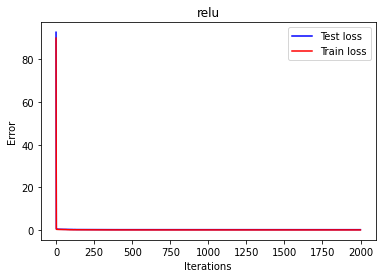

best score =  (2000, 0.16731269909446198)
Mean absolute error score for  = ('relu', 0.2878787878787879)


0.2878787878787879

In [69]:
shape=(num_inputs,6,num_classes)
activationLayer="relu"
training(shape,activationLayer)
# training(shape,"sigmoid")

In [33]:
def testRun():
    '''
    I want mse to be y axis
    I want neurons to be x axis
    then I will have 3 plots, tanh, sigmoid and relu?
    '''
    #shape = (num_inputs, 8, num_classes)

    activations = ['sigmoid','tanh']#,'relu','default']
    neurons = [4,5,6,7,8]
    arrays = np.zeros(shape=(len(activations),len(neurons)))

    for i in range(len(arrays)):
        activationLayer = activations[i]
        for k in range(len(neurons)):
            shape = (num_inputs,neurons[k],num_classes)
            mse = training(shape,activationLayer)
            arrays[i][k]=mse
            print(i,k)
     #   print(i)

    return arrays

arrays = testRun()



New best particle found at iteration #0 with mean squared error: 0.3158711559154064
New best particle found at iteration #5000 with mean squared error: 0.17613603217149595
New best particle found at iteration #10000 with mean squared error: 0.1755000923180775
best score =  (10000, 0.1755000923180775)
Mean absolute error score for  = ('sigmoid', 0.3560606060606061)
0 0
New best particle found at iteration #0 with mean squared error: 0.3630783255957778
New best particle found at iteration #5000 with mean squared error: 0.1624487999443358
New best particle found at iteration #10000 with mean squared error: 0.15968541238181894
best score =  (10000, 0.15968541238181894)
Mean absolute error score for  = ('sigmoid', 0.2992424242424242)
0 1
New best particle found at iteration #0 with mean squared error: 0.3513475589409199
New best particle found at iteration #5000 with mean squared error: 0.1207130271055023
New best particle found at iteration #10000 with mean squared error: 0.115486535632141

In [34]:
# def testRun():
#     '''
#     I want mse to be y axis
#     I want neurons to be x axis
#     then I will have 3 plots, tanh, sigmoid and relu?
#     '''
#     #shape = (num_inputs, 8, num_classes)

#     activations = ['tanh']#,'relu','default']
#     neurons = [4,5,6,7,8]
#     arrays = np.zeros(shape=(len(activations),len(neurons)))

#     for i in range(len(arrays)):
#         activationLayer = activations[i]
#         for k in range(len(neurons)):
#             shape = (num_inputs,neurons[k],num_classes)
#             mse = training(shape,activationLayer)
#             arrays[i][k]=mse
#             print(i,k)
#      #   print(i)

#     return arrays

# tanh = testRun()


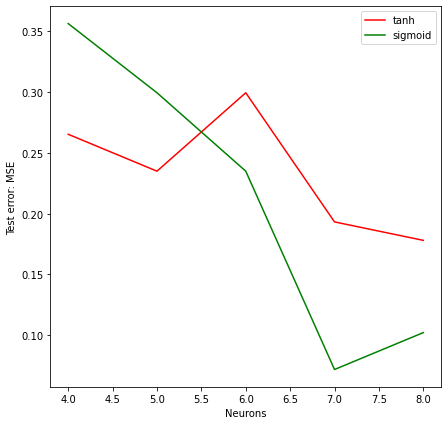

hello


In [35]:
import matplotlib.pyplot as plt

neurons = [4,5,6,7,8]
plt.figure(figsize=(7,7))
plt.plot(neurons,arrays[1],color='r',label="tanh")
plt.plot(neurons,arrays[0],color='g',label="sigmoid")
#plt.plot(neurons,arrays[2],color='c',label="relu")
#plt.plot(neurons,arrays[3],color='b',label="Identity")
plt.xlabel("Neurons")
plt.ylabel("Test error: MSE")
plt.legend()
plt.show()
print("hello")

In [127]:
'''
Using the brute force method figure out the optimal functions

then use the same functions in PSO and compare it with base line

'''

'\nUsing the brute force method figure out the optimal functions\n\nthen use the same functions in PSO and compare it with base line\n\n'

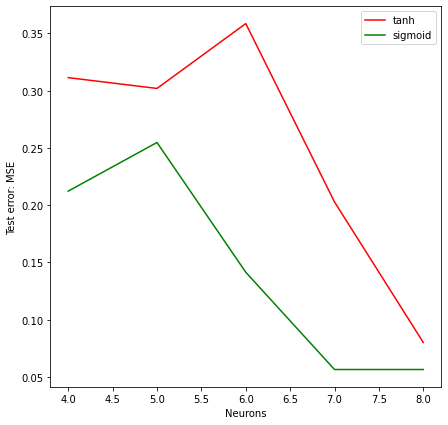

hello


In [129]:
import matplotlib.pyplot as plt

neurons = [4,5,6,7,8]
plt.figure(figsize=(7,7))
plt.plot(neurons,arrays[1],color='r',label="tanh")
plt.plot(neurons,arrays[0],color='g',label="sigmoid")
#plt.plot(neurons,arrays[2],color='c',label="relu")
#plt.plot(neurons,arrays[3],color='b',label="Identity")
plt.xlabel("Neurons")
plt.ylabel("Test error: MSE")
plt.legend()
plt.show()
print("hello")

In [35]:
np.random.seed(2)


2
